*Stanislav Borysov [stabo@dtu.dk], DTU Management*
# Advanced Business Analytics

## Interpretable Machine Learning - Part 1

*Based on https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e*

In many (business) cases it is equally important to not only have an accurate, but also an interpretable model. For instance, apart from wanting to know what our model's house price prediction is, we also wonder why it is this high/low and which features are most important in determining the forecast. Another example might be predicting customer churn : It is very nice to have a model that is successfully predicting which customers are prone to churn, but identifying which variables are important can help in early detection and maybe even improving the product/service.

Knowing feature importance indicated by machine learning models can benefit you in multiple ways, here are some examples:
- by getting a better understanding of the model's logic you can not only verify it being correct but also work on improving the model by focusing only on the important variables;
- the above can be used for variable selection : one can remove x variables that are not that significant and have similar or better performance in much shorter training time;
- in some business cases, it makes sense to sacrifice some accuracy for the sake of interpretability. For example, when a bank rejects a loan application, it must also have a reasoning behind the decision, which can also be presented to the customer.

In this first notebook, we will explore different approaches to interpreting feature importance by the example of a Random Forest model. Most of them are also applicable to different models, starting from linear regression and ending with black-boxes such as deep neural networks or XGBoost.

One thing to note is that the more accurate our model is, the more we can trust feature importance measures and other interpretations. Here, we assume that the model we build is reasonably accurate (as each data scientist will strive to have such a model) and we will mostly focus on feature importance measures.

### 1. Data

In [1]:
import pandas as pd
import numpy as np
import random
# visualisations
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FIG_SIZE = (15, 10)
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize': FIG_SIZE})
matplotlib.rcParams['figure.figsize'] = FIG_SIZE
plt.rcParams['figure.figsize'] = FIG_SIZE

In [3]:
RANDOM_SEED = 42 # set to None
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In this notebook, we will use the Boston house prices dataset for a regression task. However, the approaches described here work just as well with classification problems, the only difference is the metric used for evaluation.

In [4]:
from sklearn.datasets import load_boston
#
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

The only non-standard thing in preparing the data is the addition of a random column to the dataset. Logically, it has no predictive power over the dependent variable (Median value of owner-occupied homes in $1000's), so it should not be an important feature in the model. Let's see how it will turn out.

In [5]:
y = boston.target
X = pd.DataFrame(boston.data, columns = boston.feature_names)
X['random'] = np.random.random(size = len(X))

Let's inspect the relationship between the random feature and the target variable. As can be observed, there is no pattern on the scatterplot and the correlation is almost 0.

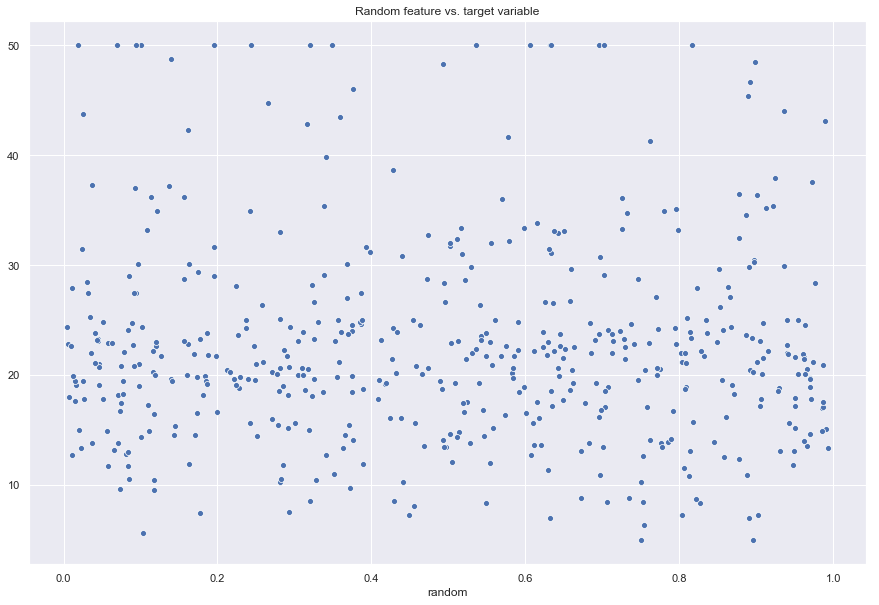

In [6]:
sns.scatterplot(X['random'], y).set_title('Random feature vs. target variable');

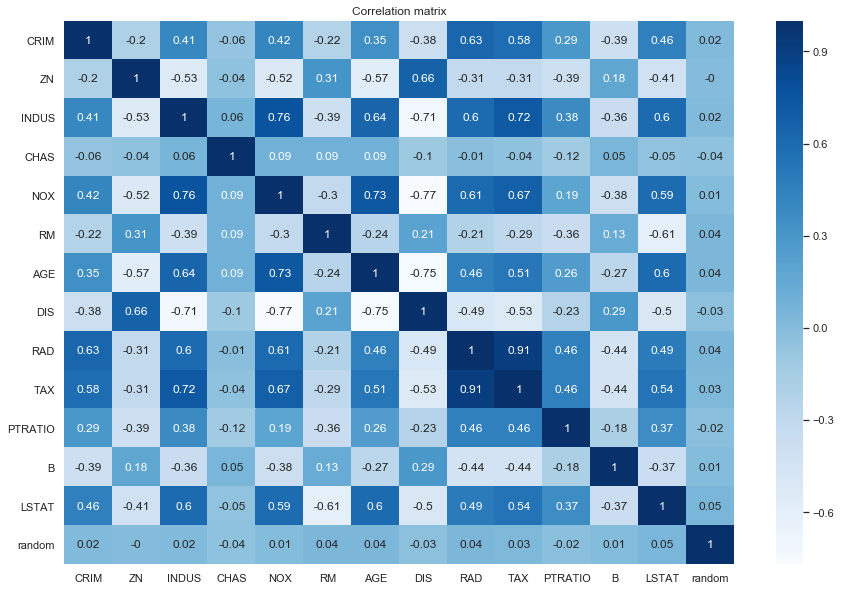

In [7]:
sns.heatmap(X.corr().round(2), cmap='Blues', annot=True)\
   .set_title('Correlation matrix');

`RAD` and `TAX` seem to be quite correlated.

In the rest of the notebook, we will use the 80/20 train/test split.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, 
                                                    random_state=RANDOM_SEED)

As usual, let's calculate performance ($R^2$) of the dummy model predicting mean value.

In [10]:
from sklearn.dummy import DummyRegressor

In [11]:
model_dummy = DummyRegressor()
model_dummy.fit(X_train, y_train)
model_dummy.score(X_test, y_test)

-0.00021485895105377573

**Helper functions**

In [12]:
def imp_df(column_names, importances):
    """Function for creating a feature importance dataframe"""
    df = pd.DataFrame({'feature': column_names, 'feature_importance': importances})\
           .sort_values('feature_importance', ascending=False)\
           .reset_index(drop=True)
    return df

def var_imp_plot(imp_df, title):
    """Plotting a feature importance dataframe (horizontal barchart)"""
    sns.barplot(x='feature_importance', y='feature', data=imp_df, 
                orient='h', color='royalblue')\
       .set_title(title, fontsize = 20)

### 2. Linear regression

Let's do some basic analysis using linear regression, which is completely a white-box model.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [14]:
model_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_regression", LinearRegression())
])
model_lr.fit(X_train, y_train)
model_lr.score(X_test, y_test)

0.7075602446924061

In [15]:
lr_imp = imp_df(X.columns, model_lr["linear_regression"].coef_)
lr_imp

,feature,feature_importance
0,RM,3.220568
1,RAD,1.321608
2,CHAS,1.107961
3,INDUS,1.085057
4,B,1.071143
5,ZN,0.347426
6,TAX,-0.067538
7,random,-0.627118
8,AGE,-0.840742
9,CRIM,-0.997481


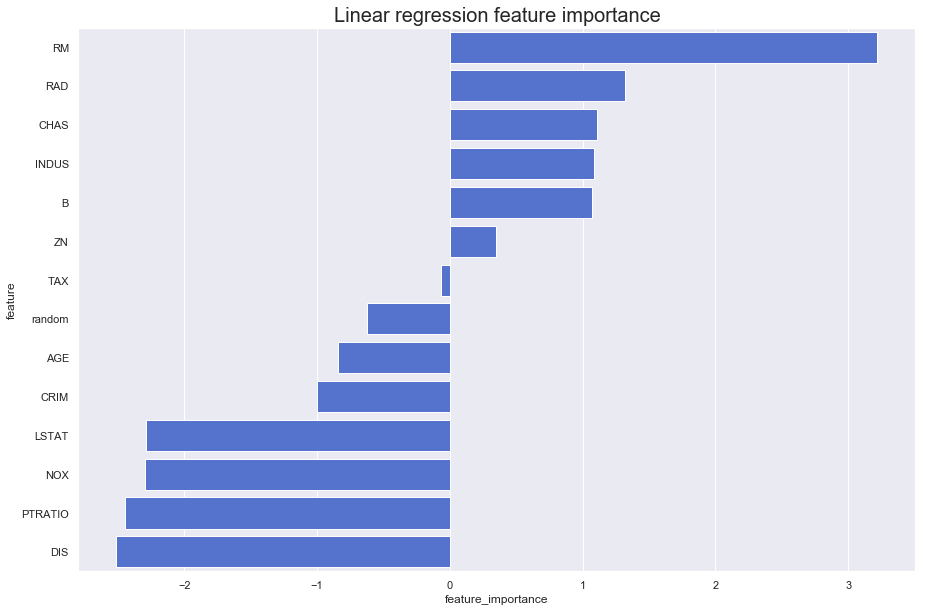

In [16]:
var_imp_plot(lr_imp, 'Linear regression feature importance')

Surprisingly, the random feature is more important than some other features. Let's calculate p-values. Unfortunately, sklearn does not provide this functionality out of the box so we will use the statsmodels package.

*This gives some version conflicts with scipy*
```
pip install statsmodels
```

*This one worked*
```
pip install statsmodels==0.10.0rc2 --pre
```

https://github.com/statsmodels/statsmodels/issues/5747

In [17]:
import statsmodels.api as sm

In [18]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     16.91
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           4.64e-19
Time:                        15:37:22   Log-Likelihood:                -292.44
No. Observations:                 101   AIC:                             614.9
Df Residuals:                      86   BIC:                             654.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.1099     13.366      1.953      0.0

/Users/borysov/py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


As you can see, the random feature is not significant. While it is possible to find statistical significance (p-values) for white-box statistical models, it is often problematic for black-box models. In general, one needs to be very careful when interpreting feature importance, especially, when the differences are low.

### 3. Random Forest

We train a plain Random Forest model for further analysis. We use bootstrap and set `oob_score = True` to use the out-of-bag error. 

Briefly, each tree in the random forest is trained on a different dataset, sampled with replacement from the original data. This results in around ~2/3 of distinct observations in each training set. The out-of-bag error is calculated on all the observations, but for calculating each row's error the model only considers trees that have not seen this row during training. This is similar to evaluating the model on a validation set. You can read more [here](https://stackoverflow.com/questions/18541923/what-is-out-of-bag-error-in-random-forests).

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
model_rf = RandomForestRegressor(n_estimators=100,
                                 oob_score=True,
                                 bootstrap=True,
                                 random_state=RANDOM_SEED)
model_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=42, verbose=0, warm_start=False)

In [21]:
print("R^2 Training Score:", model_rf.score(X_train, y_train))
print("R^2 OOB Score:", model_rf.oob_score_)
print("R^2 Test Score:", model_rf.score(X_test, y_test))

R^2 Training Score: 0.9294065652321954
R^2 OOB Score: 0.5770446391809702
R^2 Test Score: 0.75621325500442


Well, slightly better than the linear model. There is some overfitting in the model, as it performs much worse on the OOB sample and worse on the test set. But let's say it is good enough and move forward to feature importances (measured on the training set performance). Some of the approaches can also be used for test/OOB sets, to gain further interpretability on the unseen data. Please feel free to do some hyperparameter tuning to improve the model.

### 4. Global importance

Global importance means the importance derived at the model level, i.e., saying that in a given model these features are most important in explaining the target variable.

#### 4.1 Impurity decrease importance

Let's start with decision trees to build some intuition. In decision trees, every node is a condition of how to split values in a single feature, so that similar values of dependent variable end up in the same set after the split. The condition is based on impurity, which in case of classification problems is Gini impurity / information gain (entropy), while for regression trees its variance. So when training a tree we can compute how much each feature contributes to decreasing the weighted impurity. `feature_importances_` in Scikit-Learn is based on that logic, but in case of Random Forest, we are talking about averaging the decrease in impurity over trees.

**Pros:**
* fast calculation 
* easy to retrieve - one command

**Cons:**
* biased approach, as it tends to inflate the importance of continuous features or high-cardinality categorical variables
* applicable to random forests only

In [22]:
base_imp = imp_df(X.columns, model_rf.feature_importances_)
base_imp

,feature,feature_importance
0,RM,0.422139
1,LSTAT,0.304657
2,DIS,0.073838
3,CRIM,0.067455
4,PTRATIO,0.026696
5,NOX,0.021175
6,B,0.019827
7,AGE,0.018577
8,TAX,0.017824
9,random,0.010901


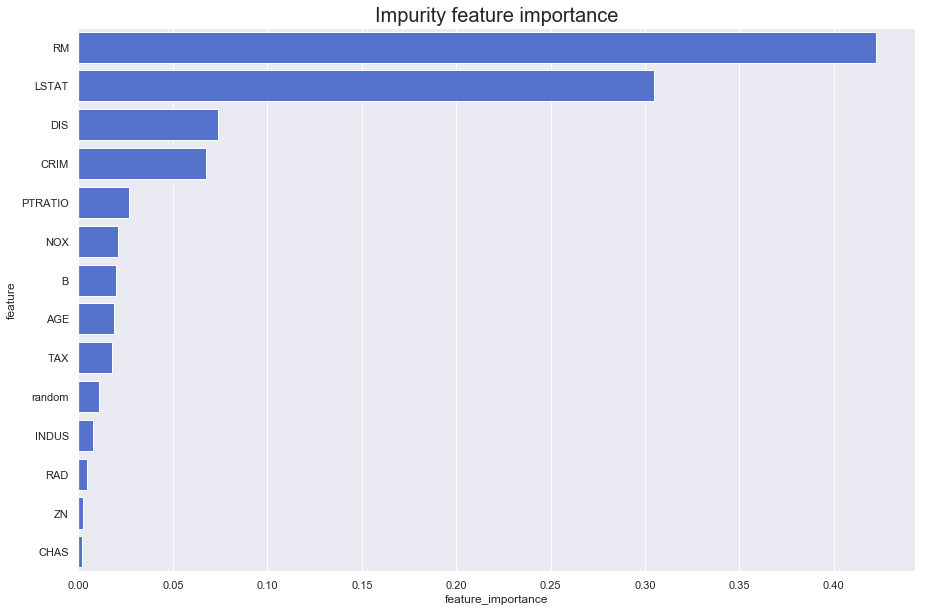

In [23]:
var_imp_plot(base_imp, 'Impurity feature importance')

It seems that the top 3 most important features are:
* average number of rooms   
* % lower status of the population
* weighted distances to five Boston employment centres

What seems surprising though is that a column of random values turned out to be more important than:
* proportion of non-retail business acres per town
* index of accessibility to radial highways
* proportion of residential land zoned for lots over 25,000 sq.ft.
* Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

Intuitively this feature should have zero importance on the target variable. Let's see how it is evaluated by different approaches.

#### 4.2 Permutation importance

This approach directly measures feature importance by observing how random re-shuffling (thus preserving the distribution of the variable) of each predictor influences model performance. 

The approach can be described in the following steps:
1. Train the baseline model and record the score (accuracy/$R^2$/any metric of importance) by passing a validation set (or OOB set in case of Random Forest). This can also be done on the training set, at the cost of sacrificing information about generalization.
2. Re-shuffle values from one feature in the selected dataset, pass the dataset to the model again to obtain predictions and calculate the metric for this modified dataset. The feature importance is the difference between the benchmark score and the one from the modified (permuted) dataset.
3. Repeat 2. for all features in the dataset.

**Pros:**
* applicable to any model
* reasonably efficient 
* reliable technique
* no need to retrain the model at each modification of the dataset

**Cons:**
* more computationally expensive than default `feature_importances`
* permutation importance overestimates the importance of correlated predictors - Strobl *et al* (2008)

**Additional materials**

- [sklearn docs: Permutation feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html)
- [sklearn docs: Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)
- [sklearn docs: Permutation Importance with Multicollinear or Correlated Features](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html)

In [24]:
from sklearn.inspection import permutation_importance

In [25]:
perm_imp_report = permutation_importance(model_rf, X_test, y_test, n_repeats=10,
                                random_state=RANDOM_SEED)

In [26]:
perm_imp_report

{'importances': array([[ 1.37459964e-02,  7.30638903e-03,  1.33428751e-02,
          1.93243711e-03,  7.24592411e-03,  1.69130319e-02,
          5.62371574e-03,  1.70965757e-02, -3.20667011e-04,
          5.15941282e-04],
        [ 2.68719678e-03,  4.15676811e-03,  3.29695586e-03,
          5.14943249e-03,  3.94755362e-03,  3.34858091e-03,
          4.11056289e-03,  3.07735350e-03,  4.67132852e-03,
          5.65214521e-03],
        [-5.02749852e-03, -6.54458717e-03, -7.56943814e-03,
         -9.06954896e-03, -7.42908809e-03, -4.17910197e-03,
         -8.16795180e-03, -6.53007548e-03, -9.24255084e-03,
         -1.16144740e-02],
        [-1.04999325e-05,  4.57056210e-04,  7.08616507e-04,
          1.68950905e-04,  8.01662563e-04,  7.87880467e-04,
          7.46334390e-04,  4.55491767e-04,  5.40668586e-04,
          7.39988245e-04],
        [ 6.51054974e-03,  5.47831078e-03,  4.89852146e-03,
          5.63237119e-03,  8.54955541e-03,  5.58107952e-03,
          6.77968244e-03,  6.01458215

In [27]:
perm_imp = imp_df(X.columns, perm_imp_report['importances_mean'])
perm_imp

,feature,feature_importance
0,RM,0.544574
1,LSTAT,0.488498
2,DIS,0.017498
3,PTRATIO,0.017048
4,CRIM,0.008340
5,NOX,0.006274
6,AGE,0.006057
7,ZN,0.004010
8,B,0.000981
9,CHAS,0.000540


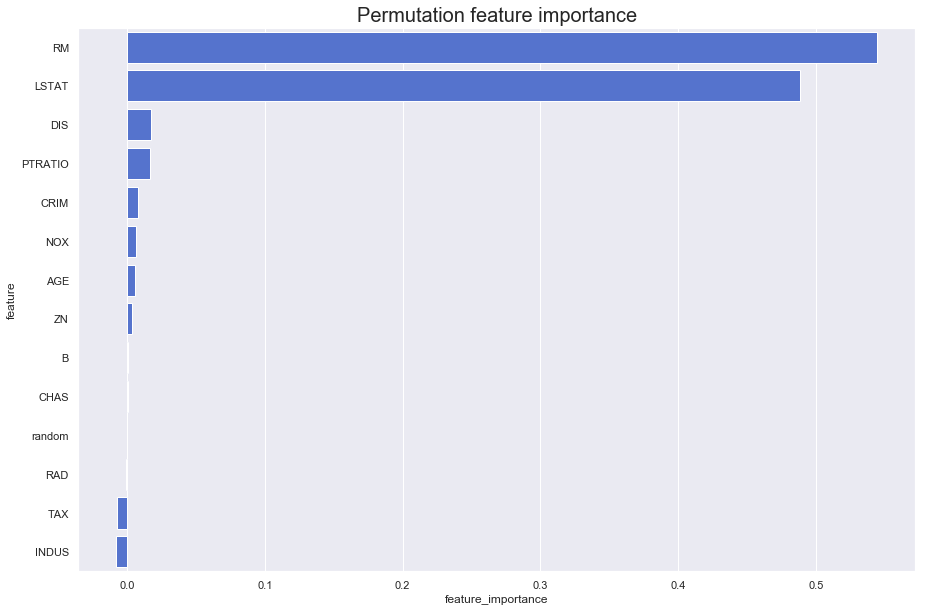

In [28]:
var_imp_plot(perm_imp, 'Permutation feature importance')

Some observations:
- `RM` and `LSTAT` remain the most important features
- random has no influence (great!)
- some features decrease performance, most probably, either due to overfitting or differences between train and test distributions

#### 4.3 Drop column importance

This approach is quite an intuitive one, as we investigate the importance of a feature by comparing a model with all features versus a model with this feature dropped for training.

**Pros:**
* applicable to any model
* slightly more accurate than permutation importance 

**Cons:**
* potentially high computation cost due to retraining the model for each variant of the dataset (after dropping a single feature column)

In [29]:
from sklearn.base import clone 

def drop_col_feat_imp(model, X_train, y_train, random_state=None):
    # clone the model to have the exact same specification 
    # as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    # iterating over all columns and storing feature importance
    # (difference between benchmark and new model)
    for col in X_train.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
        importances.append(benchmark_score - drop_col_score)
    #
    return importances

In [30]:
drop_importances = drop_col_feat_imp(model_rf, X_train, y_train, 
                                     random_state=RANDOM_SEED)

In [31]:
drop_imp = imp_df(X_train.columns, drop_importances)
drop_imp

,feature,feature_importance
0,LSTAT,0.020829
1,RM,0.006777
2,ZN,0.000913
3,INDUS,0.000756
4,CHAS,0.000715
5,NOX,0.000526
6,TAX,0.000175
7,PTRATIO,0.000154
8,CRIM,0.000083
9,B,-0.000985


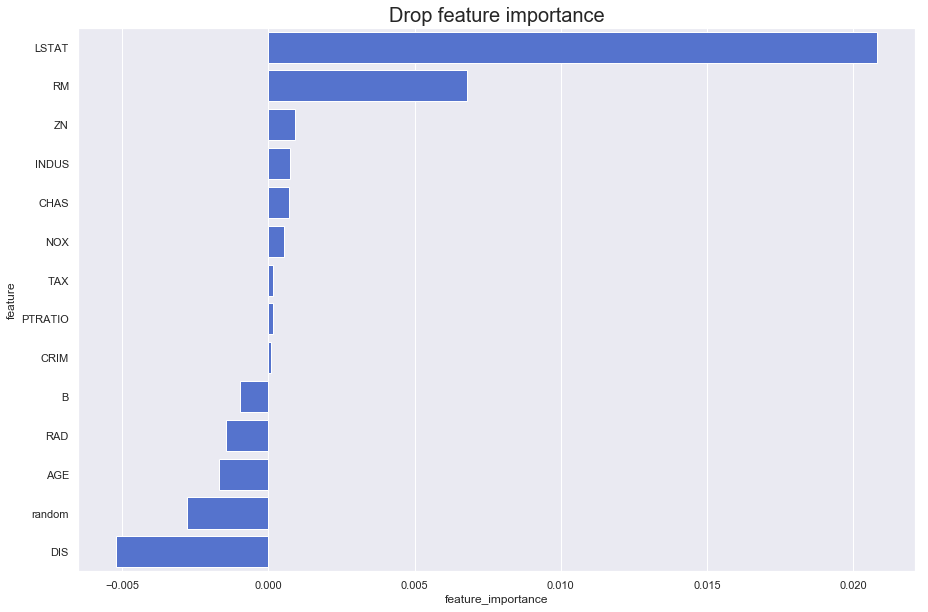

In [32]:
var_imp_plot(drop_imp, 'Drop feature importance')

Here it gets interesting. First of all, negative importance, in this case, means that removing a given feature from the model actually improves the performance. So this is nice to see in case of `random`, but what is weird is that the highest performance boost can be observed after removing `DIS`, which was the third most important variable in previous approaches, probably, due to overfitting.

**Conclusion**

There is no silver bullet solution. It is important to try several different methods to understand when they agree and disagree and why.

#### 4.4 Partial dependance plots

Partial dependence plots (PDP) show the dependence between the target response and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features. 

Due to the limits of human perception the size of the target feature set must be small (usually, one or two) thus the target features are usually chosen among the most important features.

In [33]:
from sklearn.inspection import plot_partial_dependence

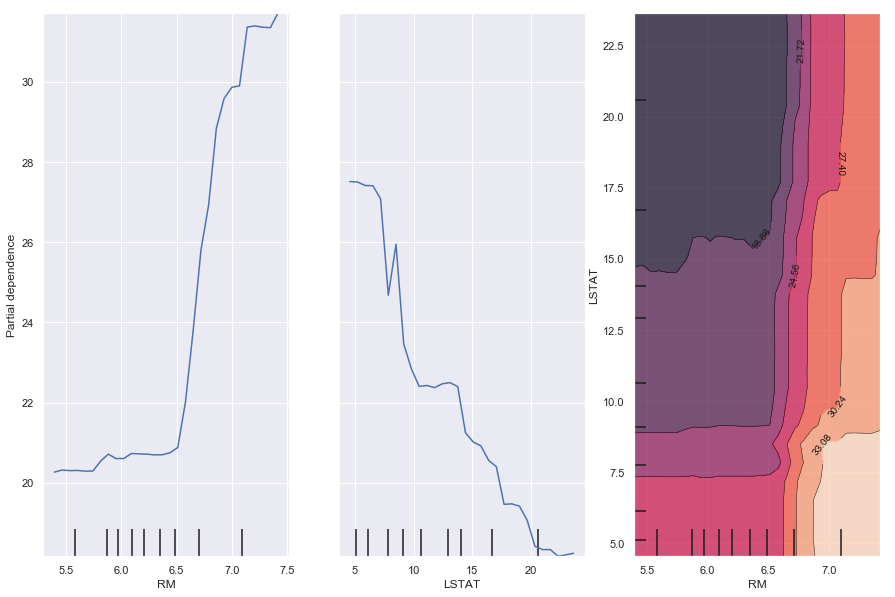

In [34]:
features = ['RM', 'LSTAT', ('RM', 'LSTAT')]
plot_partial_dependence(model_rf, X_train, features, grid_resolution=30);

One-way PDPs tell us about the interaction between the target response and the target feature (e.g. linear, non-linear). The left plot shows that the house price has an abrupt increase for `RM` > 6.5, while the dependence on the `LSTAT` variable is more or less linear.

**Additional materials**

- [sklearn docs: Partial Dependence Plots - 1](https://scikit-learn.org/stable/modules/partial_dependence.html)
- [sklearn docs: Partial Dependence Plots - 2](https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html)

### 5. Local importance

Local feature importance aims to identify features that had the most impact on explaining a particular single observation (i.e., a single sample) fed to the model. For example, in the case of credit scoring, we would be able to say that these features had the most impact on determining the credit score for a *specific* client.

#### 5.1 Treeinterpreter

```
pip install treeinterpreter
```

The main idea of `treeinterpreter` is that it uses the underlying trees in Random Forest to explain how each feature contributes to the end value. We can observe how the value of the prediction (defined as the sum of each feature contributions + average given by the initial node that is based on the entire training set) changes along the prediction path within the decision tree (after every split), together with the information which feature caused the split (so also the change in prediction).

The formula for the prediction function, $f(x)$, can be written down as:
$$ f(x) = c_{full} +\sum_{k=1}^{K}contribution(x, k)$$

where $c_{full}$ is the average of the entire dataset (initial node), $K$ is the total number of features.

This may sound complicated, but let's take a look at an example from the author of the library:

<img src="dec_tree.png">

As Random Forest's prediction is the average of the trees, the formula for average prediction is the following:

$$F(x) = \frac{1}{J} \sum_{j=1}^{J} c_{j_{full}} + \sum_{k=1}^{K}\left(\frac{1}{J}\sum_{j=1}^{J}contribution_{j}(x,k)\right)$$

where $J$ is the number of trees in the forest.

Let's start by identifying rows with the lowest and the highest absolute prediction error and try to figure out what caused the difference.

In [35]:
pred_diff = abs(y_train - model_rf.predict(X_train))
min_error_ind = np.argmin(pred_diff)
max_error_ind = np.argmax(pred_diff)
print('Index with smallest error:', min_error_ind)
print('Index with largest error:', max_error_ind)

Index with smallest error: 31
Index with largest error: 85


Using `treeintrerpreter`, we obtain 3 objects: predictions, bias (average value of the dataset) and contributions.

In [36]:
from treeinterpreter import treeinterpreter as ti, utils
#
selected_rows = [min_error_ind, max_error_ind]
selected_df = X_train.iloc[selected_rows, :].values
prediction, bias, contributions = ti.predict(model_rf, selected_df)

/Users/borysov/py3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [37]:
for i in range(len(selected_rows)):
    print("Row", selected_rows[i])
    print("Prediction:", prediction[i][0], 'Actual Value:', y_train[selected_rows[i]])
    print("Bias (trainset mean)", bias[i])
    print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], X_train.columns), 
                             key=lambda x: -abs(x[0])):
        print(feature, round(c, 2))
    print("-"*20) 

Row 31
Prediction: 21.996 Actual Value: 22.0
Bias (trainset mean) 22.544297029702978
Feature contributions:
LSTAT 3.02
RM -3.01
PTRATIO 0.36
AGE -0.29
DIS -0.21
random 0.18
RAD -0.17
NOX -0.16
TAX -0.11
CRIM -0.07
B -0.05
INDUS -0.02
ZN -0.01
CHAS -0.01
--------------------
Row 85
Prediction: 36.816 Actual Value: 50.0
Bias (trainset mean) 22.544297029702978
Feature contributions:
DIS 7.7
LSTAT 3.33
RM -1.88
CRIM 1.87
TAX 1.32
NOX 1.02
B 0.54
CHAS 0.36
PTRATIO -0.25
RAD 0.17
AGE 0.13
INDUS -0.03
random -0.01
ZN 0.0
--------------------


For the observation with the smallest error, the main contributor was `LSTAT` and `RM` (which in previous cases turned out to be the most important variables). In the highest error case, the highest contribution came from `DIS` variable, overcoming the same two variables that played the most important role in the first case.

To dive even deeper, we might also be interested in the joined contribution of many variables (as explained in the case of XOR [here](http://blog.datadive.net/random-forest-interpretation-conditional-feature-contributions/)). We will go right to the example, more information can be found under the link.

In [38]:
prediction1, bias1, contributions1 = ti.predict(model_rf, 
                                                np.array([selected_df[0]]), 
                                                joint_contribution=True)
prediction2, bias2, contributions2 = ti.predict(model_rf, 
                                                np.array([selected_df[1]]), 
                                                joint_contribution=True)

In [39]:
aggregated_contributions1 = utils.aggregated_contribution(contributions1)
aggregated_contributions2 = utils.aggregated_contribution(contributions2)

In [40]:
res = []
for k in set(aggregated_contributions1.keys()).union(
              set(aggregated_contributions2.keys())):
    res.append(([X_train.columns[index] for index in k], 
               aggregated_contributions1.get(k, 0) \
                - aggregated_contributions2.get(k, 0)))   
         
for lst, v in (sorted(res, key=lambda x:-abs(x[1])))[:10]:
    print (lst, v)

['RM', 'DIS'] [-3.65430351]
['RM', 'DIS', 'LSTAT'] [-2.15540094]
['CRIM', 'LSTAT'] [-1.65588589]
['DIS', 'LSTAT'] [-1.64678593]
['NOX', 'LSTAT'] [-1.28406056]
['RM', 'TAX', 'LSTAT'] [-1.00245007]
['CRIM', 'RM', 'LSTAT'] [-0.62160057]
['TAX', 'LSTAT'] [-0.55742577]
['RM', 'LSTAT'] [-0.45002332]
['B', 'LSTAT'] [-0.3516441]


Most of the difference between the best and worst predicted cases comes from the number of rooms (`RM`) feature, in conjunction with weighted distances to five Boston employment centres (`DIS`).

#### 5.2 Local Interpretable Model-agnostic Explanations (LIME)

```
pip install lime
```

**WARNING! LIME OUTPUT DOES NOT WORK IN JUPYTER LAB. YOU NEED TO RUN THE CODE IN JUPYTER NOTEBOOK INSTEAD.**

LIME (Local Interpretable Model-agnostic Explanations) is a technique explaining the predictions of any classifier/regressor in an interpretable and faithful manner. To do so, an explanation is obtained by locally approximating the selected model with an interpretable one (such as linear models with regularisation or decision trees). The interpretable models are trained on small perturbations (adding noise) of the original observation (row in case of tabular data), thus they only provide a good local approximation. 

Some drawbacks to be aware of:
* only linear models are used to approximate local behaviour
* type of perturbations that need to be performed on the data to obtain correct explanations are often use-case specific
* simple (default) perturbations are often not enough. In an ideal case, the modifications would be driven by the variation that is observed in the dataset

You can check the original paper here: https://arxiv.org/abs/1602.04938

In [41]:
from lime.lime_tabular import LimeTabularExplainer

In [42]:
explainer = LimeTabularExplainer(X_train.values,
                                 mode='regression',
                                 feature_names = X_train.columns,
                                 categorical_features=[3], 
                                 categorical_names=['CHAS'], 
                                 discretize_continuous=True)

Below you can see the output of LIME interpretation. 

There are 3 parts of the output:
1. Predicted value
2. Feature importance - in case of regression it shows whether it has a negative or positive impact on the prediction, sorted by absolute impact descending. 
3. Actual values of these features for the explained rows.

Note that LIME has discretized the features in the explanation. This is because of setting `discretize_continuous=True` in the constructor above. The reason for discretization is that it gives continuous features more intuitive explanations.

In [43]:
exp = explainer.explain_instance(X_train.values[min_error_ind], 
                                 model_rf.predict, num_features=5)
exp.show_in_notebook(show_all=False) 
# only the features used in the explanation are displayed

In [44]:
exp = explainer.explain_instance(X_train.values[max_error_ind], 
                                 model_rf.predict, num_features=5)
exp.show_in_notebook(show_all=False)
# only the features used in the explanation are displayed

LIME interpretation agrees that for these two observations the most important features are `RM` and `LSTAT`, which was also indicated by previous approaches.

### 6. Additional reading

* [Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)
* [Conditional variable importance for random forests](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-307)
* [Interpreting random forests](http://blog.datadive.net/interpreting-random-forests/)
* [Random forest interpretation – conditional feature contributions](http://blog.datadive.net/random-forest-interpretation-conditional-feature-contributions/)
* [Kaggle tutorial on Machine Learning Explainability](https://www.kaggle.com/learn/machine-learning-explainability)